# Test of the dose units

This notebook is simply a check that the units are correct for the dose calculation.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.28/06


In [2]:
%matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
# plt.rcParams['figure.dpi'] = 100
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [4]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

## Physics / simulation setup

In [5]:
SI_e = 1.60217662e-19 #[C]

In [6]:
### Basic simulation parameters ###

QUIET   = False #Reduce the ammount of output
TRYLOAD = True  #Try to load already existing data instead of recomputing?

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
baseSimSetup["PHYS"]  = "QGSP_BERT"
baseSimSetup["N"]     = 10000

baseSimSetup["ENERGY"] = 215.0 #[MeV]
baseSimSetup["ZOFFSET"]           = 0.0

baseSimSetup["WORLDSIZE"] = 1000.0 #Make the world wider, to contain the shower

baseSimSetup["DIST"] = 3000.0 #Detector distance from target center [mm]

baseSimSetup["QUICKMODE"] = False  #Include slow plots
baseSimSetup["MINIROOT"]  = True   #Skip TTRees in the .root files
baseSimSetup["EDEP_DZ"]   = 1.0    #Z-binning for energy deposition plots

baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"DoseDeposition_unitsCheck")
baseSimSetup["THICK"] = 3000
baseSimSetup["MAT"] = "G4_WATER"

## Simulation / Electrons

In [7]:
baseSimSetup_e = baseSimSetup.copy()
baseSimSetup_e["BEAM"] = "e-"
baseSimSetup_e["OUTNAME"]="electrons"

baseSimSetup_e["N"]=10000

(twiss_e, numPart_e, objects_e) = miniScatterDriver.getData_tryLoad(baseSimSetup_e, tryload=True,\
    getObjects=["targetEdep","target_edep_dens","target_edep_rdens","metadata"])

Did not find any pre-computed data at '/mn/fys-server1/a9/kyrrens/MiniScatter/examples/DoseDeposition_unitsCheck/electrons.root', computing now.
Running command line: './MiniScatter --thick 3000 --mat G4_WATER --dist 3000.0 --worldsize 1000.0 --phys QGSP_BERT --numEvents 10000 --energy 215.0 --beam e- --zoffset 0.0 --outname electrons --outfolder /mn/fys-server1/a9/kyrrens/MiniScatter/examples/DoseDeposition_unitsCheck --miniroot --edepDZ 1.0'
RunFolder = '/mn/fys-server1/a9/kyrrens/MiniScatter/build'
logName   = '/mn/fys-server1/a9/kyrrens/MiniScatter/examples/DoseDeposition_unitsCheck/electrons.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
-
Done!


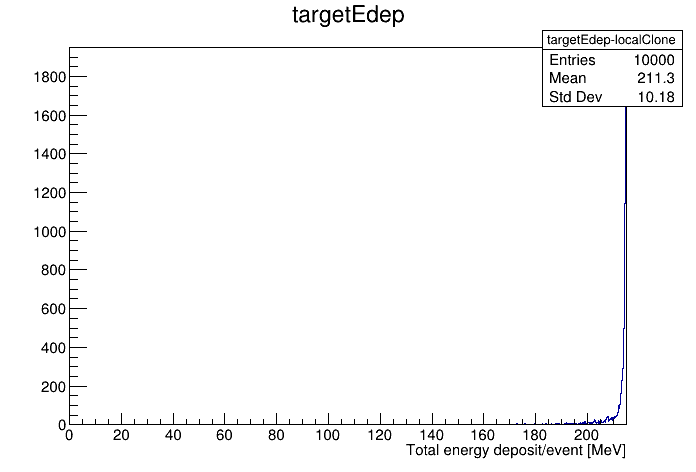

In [8]:
c1 = ROOT.TCanvas()
objects_e['targetEdep'].Draw()
c1.Draw()

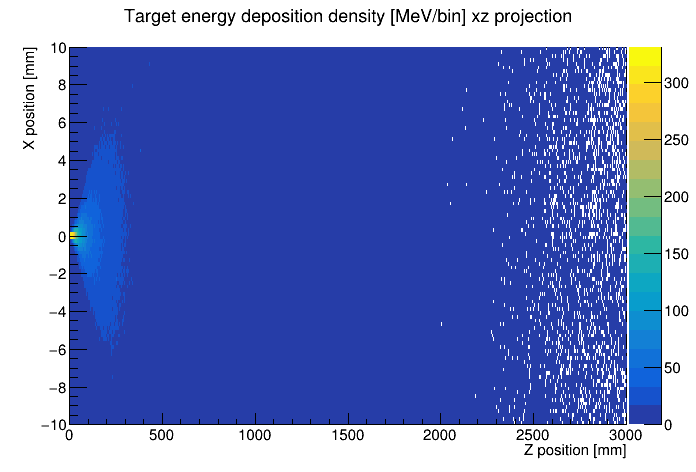

In [9]:
c2 = ROOT.TCanvas()
objects_e['target_edep_dens_xz'] = objects_e['target_edep_dens'].Project3D('xz')
#objects_e['target_edep_dens_xz'].SetContour(100, np.linspace(0,0.3,100))
objects_e['target_edep_dens_xz'].SetStats(False)
objects_e['target_edep_dens_xz'].Draw('colz')
c2.Draw()

In [10]:
#Compute the various scalings

nElec = (1e-9/SI_e) # 1 nC of electrons
scaleFactor_nElec = nElec/baseSimSetup_e["N"] # physical electrons / simulated electrons
scaleFactor_energyUnit = 1.6021766e-13 #J/MeV
scaleFactor_binVolume = objects_e['target_edep_dens'].GetXaxis().GetBinWidth(1)*\
                        objects_e['target_edep_dens'].GetYaxis().GetBinWidth(1)*\
                        objects_e['target_edep_dens'].GetZaxis().GetBinWidth(1)*1e-3 #[cm^3]
scaleFactor_density = objects_e['metadata'][2]*1e-3 #[kg/cm^3]
scaleFactor = scaleFactor_nElec * scaleFactor_energyUnit / (scaleFactor_binVolume * scaleFactor_density)

print("nElec                  =", nElec, "[e-]")
print("nEvents                =", baseSimSetup_e["N"], "[events]")
print("scaleFactor_nElec      =", scaleFactor_nElec, "[physical electrons/simulated electrons]")
print("scaleFactor_energyUnit =", scaleFactor_energyUnit, "[J/MeV]")
print("binWidths (X/Y/Z)      =", objects_e['target_edep_dens'].GetXaxis().GetBinWidth(1), \
                                  objects_e['target_edep_dens'].GetYaxis().GetBinWidth(1), \
                                  objects_e['target_edep_dens'].GetZaxis().GetBinWidth(1), \
                                  "[mm]")
print("scaleFactor_binVolume  =", scaleFactor_binVolume, "[cm^3]")
print("scaleFactor_density    =", scaleFactor_density, "[kg/cm^3]")
print("scaleFactor            =", scaleFactor, "[Gy/(MeV/bin)]")

nElec                  = 6241509128.999773 [e-]
nEvents                = 10000 [events]
scaleFactor_nElec      = 624150.9128999773 [physical electrons/simulated electrons]
scaleFactor_energyUnit = 1.6021766e-13 [J/MeV]
binWidths (X/Y/Z)      = 0.2 0.2 1.0 [mm]
scaleFactor_binVolume  = 4.000000000000001e-05 [cm^3]
scaleFactor_density    = 0.001 [kg/cm^3]
scaleFactor            = 2.4999999687924532 [Gy/(MeV/bin)]


In [11]:
#Units check, virtual calorimetry

#This is assuming that everything gets absorbed IN the block
print("Expected total energy     =", nElec*scaleFactor_energyUnit*baseSimSetup_e["ENERGY"], "[J]")

#Should be slightly less, since some may escape
targetEdepIntegral = 0.0
for bin in range(1, objects_e['targetEdep'].GetNbinsX()+1):
    targetEdepIntegral += objects_e['targetEdep'].GetBinContent(bin) * \
                          objects_e['targetEdep'].GetBinCenter(bin)
targetEdepIntegral *= scaleFactor_energyUnit*scaleFactor_nElec
print("Sum over edep/event       =", targetEdepIntegral, "[J]")

print("Sum over deposits (x/y/z) =", objects_e['target_edep_dens'].Integral(0,objects_e['target_edep_dens'].GetNbinsX()+1,\
                                                                            0,objects_e['target_edep_dens'].GetNbinsY()+1,\
                                                                            0,objects_e['target_edep_dens'].GetNbinsZ()+1)\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, \
                                   "[J] (including overflow bins)")
print("Sum over deposits (x/y/z) =", objects_e['target_edep_dens'].Integral()\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (excluding overflow bins)")

print("Sum over deposits (r)     =", objects_e['target_edep_rdens'].Integral(0,objects_e['target_edep_rdens'].GetNbinsX()+1,\
                                                                           0,objects_e['target_edep_rdens'].GetNbinsY()+1)\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (including overflow bins)")
print("Sum over deposits (r)     =", objects_e['target_edep_rdens'].Integral()\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (excluding overflow bins)")

Expected total energy     = 0.21499999731615108 [J]
Sum over edep/event       = 0.20248920976003573 [J]
Sum over deposits (x/y/z) = 0.2113475590568774 [J] (including overflow bins)
Sum over deposits (x/y/z) = 0.05370976443604367 [J] (excluding overflow bins)
Sum over deposits (r)     = 0.21134755905685526 [J] (including overflow bins)
Sum over deposits (r)     = 0.08191454641778977 [J] (excluding overflow bins)


We see that when including the overflow bins (i.e. whatever is outside of $x,y \in \pm$ `RootFileWriter::phasespacehist_posLim = 10.0*mm` or $r \in [0,$ `2*RootFileWriter::phasespacehist_posLim = 20*mm`$]$), we account for the whole expected energy deposition by summing over the histograms, less a little bit that probably was backscattered and escaped somehow.
However when only taking whatever is inside these limits, we get a smaller number, and the two ways are roughly consistent. Note that the volumes are not the same, with the cartesian prism-like volume including "corners" that are excluded from the cylindrical.

Next step is to check the units using the scaled plots which are given in terms of dose \[Gy = J/kg\].
This is defined as
$$
D = \Delta E/M
$$
where $D$ is the dose deposited in some object, $\Delta E$ the enery deposited in the same object, and $M$ the mass of the object.

For a distribution $D(\vec r)$ this implies that
$$
D(\vec r) = \frac{\Delta E(\vec r)}{\rho \; \mathrm{d}V} \, ,
$$
where $\rho$ is the mass density, so that
$$
\Delta E = \int_{\forall V} D(\vec r) \; \rho \; \mathrm{d}V \, .
$$
For a volume of constant density, we can pull the mass density outside.

In [12]:
objects_e['target_edep_dens_scaled'] = ROOT.TH3D(objects_e['target_edep_dens'])
objects_e['target_edep_dens_scaled'].Scale(scaleFactor)
objects_e['target_edep_dens_scaled'].SetTitle("Target dose distribution [Gy]")

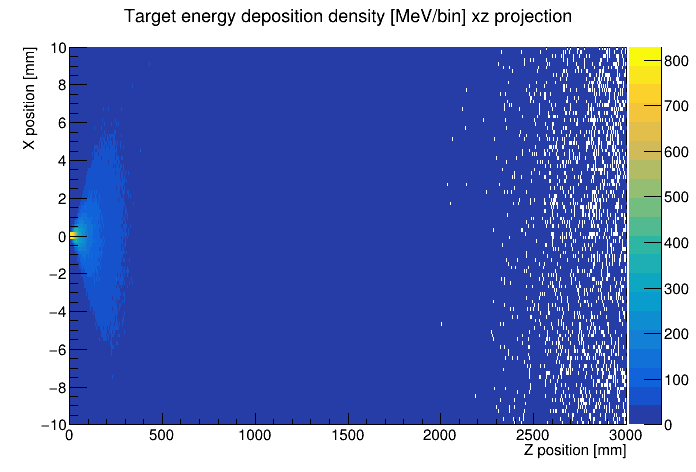

In [13]:
c3 = ROOT.TCanvas()
objects_e['target_edep_dens_scaled_xz'] = objects_e['target_edep_dens_scaled'].Project3D('xz')
#print(objects_e['target_edep_dens_scaled'].GetTitle())
#print(objects_e['target_edep_dens_scaled_xz'].GetTitle())
#objects_e['target_edep_dens_xz'].SetContour(100, np.linspace(0,0.3,100))
objects_e['target_edep_dens_scaled_xz'].SetStats(False)
objects_e['target_edep_dens_scaled_xz'].Draw('colz')
c3.Draw()

In [14]:
#Remember to scale the integral binvolume from mm3 to cm3!
print("Integrated dose (x/y/z) = ", objects_e['target_edep_dens_scaled'].Integral('width')*1e-3 * \
                                    scaleFactor_density, \
                                    "[J]")

Integrated dose (x/y/z) =  0.053709764436066065 [J]


That looks correct!

Note that the point at the entrance is effectively a singularity.

## Radial distribution

For a azimuthally symmetric problem like the one we're treating here, the "radial" r/z distribution is more interesting. However here we need to take care that the volume element changes with r.

This is done in the `miniScatterPlots` routines, which are available as both Python and a C++ implementations.

In [15]:
import time

### Python version

Walltime = 25.03672170639038 [s]


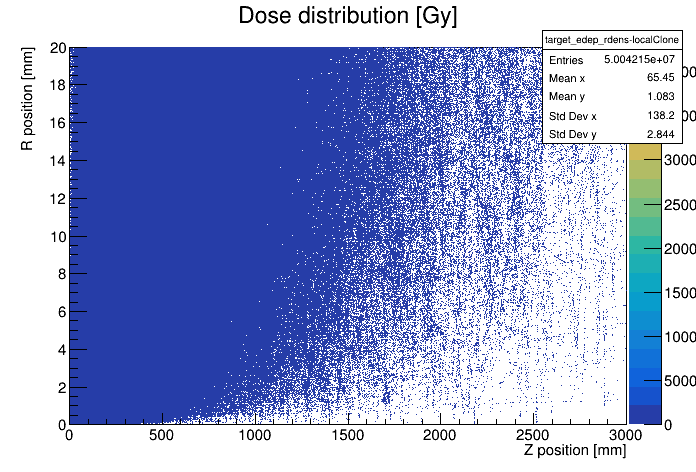

In [16]:
t1 = time.time()

rzScaled_ePy = miniScatterPlots.plotRZgray(objects_e,\
                                           baseSimSetup_e["N"], 1e-9/SI_e,
                                           forcePython=True)
c4Py = ROOT.TCanvas()
#rzScaled_e.SetContour(100, np.linspace(0,100,100))
#rzScaled_e.GetXaxis().SetRangeUser(0,400)
#rzScaled_e.GetYaxis().SetRangeUser(0,10)
rzScaled_ePy.Draw('colz')
c4Py.Draw()

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s]")

In [17]:
#Let's integrate that back again to see that we can find back the total deposited energy.

t1 = time.time()

rzScaled_ePy_integral = 0.0;
for rIdx in range(1,rzScaled_ePy.GetNbinsY()):
    dA = np.pi*(rzScaled_ePy.GetYaxis().GetBinUpEdge(rIdx)**2 - rzScaled_ePy.GetYaxis().GetBinLowEdge(rIdx)**2) #[mm^2]
    for zIdx in range(1,rzScaled_ePy.GetNbinsX()):
        dZ = rzScaled_ePy.GetXaxis().GetBinUpEdge(zIdx)-rzScaled_ePy.GetXaxis().GetBinLowEdge(zIdx) #[mm]
        dV = dA*dZ*1e-3 #[cm^3]
        rzScaled_ePy_integral += rzScaled_ePy.GetBinContent(zIdx,rIdx)*scaleFactor_density*dV
print("Integrated dose (r) = ", rzScaled_ePy_integral, "[J]")

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s]")

Integrated dose (r) =  0.08185762587450426 [J]
Walltime = 21.0438871383667 [s]


That's the same as above! It looks like it all matches up.

### C++ version

Walltime = 0.7672152519226074 [s]


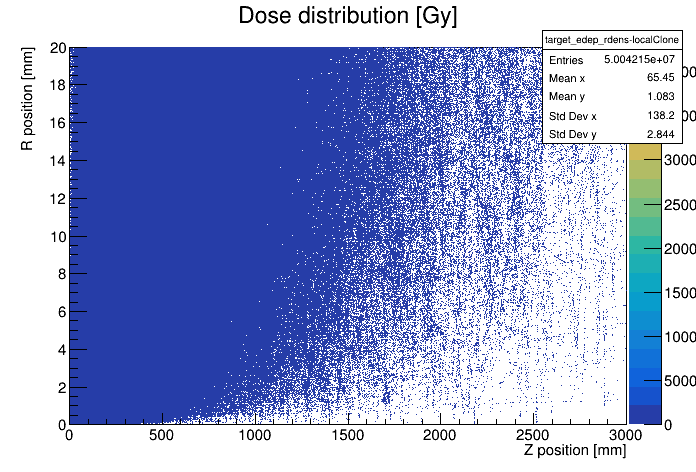

In [18]:
t1 = time.time()

rzScaled_eCPP = miniScatterPlots.plotRZgray(objects_e,\
                                            baseSimSetup_e["N"], 1e-9/SI_e,
                                            forcePython=False)
c4CPP = ROOT.TCanvas()
#rzScaled_eCPP.SetContour(100, np.linspace(0,100,100))
#rzScaled_eCPP.GetXaxis().SetRangeUser(0,400)
#rzScaled_eCPP.GetYaxis().SetRangeUser(0,10)
rzScaled_eCPP.Draw('colz')
c4CPP.Draw()

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s]")

Wow, that's a factor > 60 speedup, from ~1 minute to ~1 second!

In [19]:
#Let's integrate that back again to see that we can find back the total deposited energy.

t1 = time.time()

rzScaled_eCPP_integral = 0.0;
for rIdx in range(1,rzScaled_eCPP.GetNbinsY()):
    dA = np.pi*(rzScaled_eCPP.GetYaxis().GetBinUpEdge(rIdx)**2 - rzScaled_eCPP.GetYaxis().GetBinLowEdge(rIdx)**2) #[mm^2]
    for zIdx in range(1,rzScaled_eCPP.GetNbinsX()):
        dZ = rzScaled_eCPP.GetXaxis().GetBinUpEdge(zIdx)-rzScaled_eCPP.GetXaxis().GetBinLowEdge(zIdx) #[mm]
        dV = dA*dZ*1e-3 #[cm^3]
        rzScaled_eCPP_integral += rzScaled_eCPP.GetBinContent(zIdx,rIdx)*scaleFactor_density*dV
print("Integrated dose (r) = ", rzScaled_eCPP_integral, "[J]")

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s]")

Integrated dose (r) =  0.08185762587450426 [J]
Walltime = 21.616244316101074 [s]


Got exactly the same output with Python and C++ :)

### PlotZgray()

Walltime = 15.677512884140015 [s] (Python)
Walltime = 0.22376155853271484 [s] (Python)


Warning in <TROOT::Append>: Replacing existing TH1: target_edep_rdens-localClone_centralColumn (Potential memory leak).


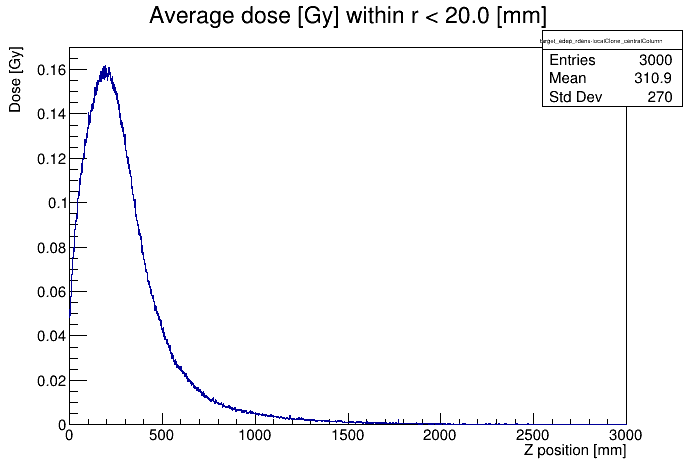

In [20]:
# Let's try the plotZgray routine

t1 = time.time()

rMaxPy = rzScaled_ePy.GetYaxis().GetBinUpEdge(rzScaled_ePy.GetNbinsY())
zGrayPy  = miniScatterPlots.plotZgray(rzScaled_ePy, rMaxPy, forcePython=True)

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s] (Python)")

t1 = time.time()
rMaxCPP = rzScaled_ePy.GetYaxis().GetBinUpEdge(rzScaled_eCPP.GetNbinsY())
zGrayCPP = miniScatterPlots.plotZgray(rzScaled_eCPP, rMaxCPP, forcePython=False)

t2 = time.time()
dt = t2-t1
print("Walltime =", dt, "[s] (Python)")

c5 = ROOT.TCanvas()
zGrayPy.Draw()
zGrayCPP.Draw("same")
c5.Draw()

Again same plot (on top of each other), and a factor ~60 speedup :)

In [21]:
#Can we get back the energy?

#Remember mm -> cm
print("Integrated dose = ", zGrayPy. Integral("width")*(np.pi*rMaxPy **2)*1e-3 * scaleFactor_density, "[J] (Python)")
print("Integrated dose = ", zGrayCPP.Integral("width")*(np.pi*rMaxCPP**2)*1e-3 * scaleFactor_density, "[J] (CPP)")

Integrated dose =  0.08191454641777975 [J] (Python)
Integrated dose =  0.08191454641777975 [J] (CPP)


Looks same-ish as before!